## Self-Driving Car Engineer Nanodegree

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Set dependency

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os, sys 
sys.path.append('lib/')
from vtcv.dataset import visualize_dataset as vd
from functools import partial
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import math
import imageio
imageio.plugins.ffmpeg.download()

##### Functions from previous step

In [2]:
def undistort_img(img, camparam, dpRslt=False):
    '''
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    undist = undist[y:y+h, x:x+w]
    '''
    undist = cv2.undistort(img, camparam['mtx'], camparam['dist'], None, camparam['mtx'])
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        axs[0].imshow(img)
        axs[1].imshow(undist)
        
    return undist

def hls_denoised_lanefilter(img, dpRslt=False) :
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    if dpRslt :
        fig, axs = plt.subplots(1,4, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.01)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]  
    
    if dpRslt :
        axs[0].set_title("l_channel")
        axs[0].imshow(l_channel,cmap='gray')
    
    #filter_out = cv2.bilateralFilter(filter_out,50,50,50)
    #filter_out = cv2.fastNlMeansDenoisingColored(filter_out,None,10,10,7,21)    
    s_channel=cv2.medianBlur(s_channel,11)
    
    if dpRslt :
        axs[1].set_title("s_channel  ")
        axs[1].imshow(s_channel,cmap='gray')

    l_s_merge = cv2.addWeighted(l_channel,0.5,s_channel,0.5,0)
    l_s_merge = cv2.dilate(l_s_merge, (10,10), iterations=5)
    if dpRslt :
        axs[2].set_title("l_channel + s_channel ")
        axs[2].imshow(l_s_merge,cmap='gray')
    
    #filter_out = cv2.bilateralFilter(filter_out,50,50,50)
    median_blur_l_s_merge=cv2.medianBlur(l_s_merge,11)
    #filter_out = cv2.fastNlMeansDenoisingColored(filter_out,None,10,10,7,21)

    if dpRslt :
        axs[3].set_title("apply median blur")
        axs[3].imshow(median_blur_l_s_merge,cmap='gray')
    
    merged_out = cv2.addWeighted(l_s_merge,0.7,median_blur_l_s_merge,0.6,0)
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]
        axs[0].imshow(img)
        axs[1].imshow(merged_out,cmap='gray')
        
    # Return the binary image
    return merged_out 

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), dilate=0, dpRslt=False):
    # Convert to grayscale
    if len(img.shape) > 2 :
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else :
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    #abs_sobel = cv2.GaussianBlur(abs_sobel,(7,7),0) # thresh = (0.5,1.2) , (0.3,1.3)        
    abs_sobel[(abs_sobel < thresh[0]) | (abs_sobel > thresh[1])] = 0
    
    if dilate > 0 :
        abs_sobel = cv2.dilate(abs_sobel, (10,10), iterations=dilate)
        
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        axs[1].imshow(abs_sobel,cmap='gray')
        
    return abs_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dilate=0, dpRslt=False):
    # Convert to grayscale
    if len(img.shape) > 2 :
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else :
        gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    #gradmag = cv2.GaussianBlur(gradmag,(7,7),0) # thresh = (0.5,1.2) , (0.3,1.3)
    gradmag[(gradmag < mag_thresh[0]) | (gradmag > mag_thresh[1])] = 0
        
    # Create a binary image of ones where threshold is met, zeros otherwise
    if dilate > 0 :    
        gradmag = cv2.dilate(gradmag, (10,10), iterations=dilate)
        
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        axs[1].imshow(gradmag,cmap='gray')
        
    return gradmag

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), dilate=0, dpRslt=False):
    # Grayscale
    if len(img.shape) > 2 :
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else :
        gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        
    #print ("absgraddir max : ", np.max(absgraddir))
    #print ("absgraddir min : ", np.min(absgraddir))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 255 
    #absgraddir[(absgraddir < thresh[0]) | (absgraddir > thresh[1])] = 0
    if dilate > 0 :    
        binary_output = cv2.dilate(binary_output, (10,10), iterations=dilate)
        
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        axs[1].imshow(binary_output,cmap='gray')
        
    # Return the binary image
    return binary_output

# Apply each of the thresholding functions
def frame_binaryzation(img,dspRslt=False, thresh=(200,255), dspDebug=False) :
    if dspDebug :
        fig, axs = plt.subplots(2,5, figsize=(16, 5))
        fig.subplots_adjust(hspace = .001, wspace=.01)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]  
    
    ## Bilateral_HLS 
    bilateral_hls = hls_denoised_lanefilter(img,dpRslt=False) 
    if dspDebug :
        axs[0].set_title("Bilateral HLS ")
        axs[0].imshow(bilateral_hls,cmap='gray')
    
    # sobel x on RGB + sobel x on HLS
    sobx = abs_sobel_thresh(bilateral_hls, orient='x', thresh=(0,255), dilate=3, dpRslt=False )
    if dspDebug :
        axs[1].set_title("abs_sobel_thresh x")
        axs[1].imshow(sobx,cmap='gray')

    soby = abs_sobel_thresh(bilateral_hls, orient='y', thresh=(0,255), dilate=3, dpRslt=False )
    if dspDebug :
        axs[2].set_title("abs_sobel_thresh y")
        axs[2].imshow(soby,cmap='gray')

    magth = mag_thresh(bilateral_hls, mag_thresh=(0, 255), dilate=2, dpRslt=False )
    if dspDebug :
        axs[3].set_title("mag_thresh")
        axs[3].imshow(magth,cmap='gray')

    #gblr = cv2.GaussianBlur(bilateral_hls,(21,21),0) # thresh = (0.5,1.2) , (0.3,1.3)
    dirth = dir_threshold(bilateral_hls, sobel_kernel=15, thresh=(0.3, 1.3), dilate=2, dpRslt=False)
    if dspDebug :
        axs[4].set_title("dir_threshold")
        axs[4].imshow(magth,cmap='gray')
    
    bilateral_hls= bilateral_hls.astype(np.float64)
    magth = magth.astype(np.float64)
    sobel_result = cv2.addWeighted(sobx, 0.5, soby, 0.5, 0)
    if dspDebug :
        axs[5].set_title("sobel_result")
        axs[5].imshow(sobel_result,cmap='gray')

    sob_grad_result = cv2.addWeighted(sobel_result, 0.3, magth, 0.7, 0)
    if dspDebug :
        axs[6].set_title("sob_grad_result")
        axs[6].imshow(sob_grad_result,cmap='gray')
    
    hls_drith_mask = cv2.addWeighted(bilateral_hls, 0.9, dirth, 0.3, 0)
    if dspDebug :
        axs[7].set_title("hls_dirth_mask")
        axs[7].imshow(hls_drith_mask,cmap='gray')

    lane_recog_mask= cv2.addWeighted(sob_grad_result, 0.7, hls_drith_mask, 0.3, 0)
    if dspDebug :
        axs[8].set_title("lane_recog_mask")
        axs[8].imshow(lane_recog_mask,cmap='gray')
    
    final_lane_mask= cv2.addWeighted(bilateral_hls, 0.3, lane_recog_mask, 0.7, 0)
    if dspDebug :
        axs[9].set_title("final_lane_mask")
        axs[9].imshow(final_lane_mask,cmap='gray')

    final_lane_mask = cv2.erode(final_lane_mask, (5,5), iterations=2)
    #final_lane_mask = cv2.GaussianBlur(final_lane_mask,(5,5),0)   
    binary_output =  np.zeros_like(final_lane_mask)
    binary_output[(final_lane_mask >= thresh[0]) & (final_lane_mask <= thresh[1])] = 255 

    #lx = abs_sobel_thresh(binary_output, orient='x', thresh=(0,255), dilate=2, dpRslt=False )
    #ly = abs_sobel_thresh(binary_output, orient='y', thresh=(0,255), dilate=2, dpRslt=False )
    #binary_output[(lx > 100) & (ly>100) & (binary_output>200) ] = 255

    #colored_binary = cv2.merge([binary_output,binary_output,binary_output])
    #output = colored_binary
    #output = cv2.Canny(colored_binary,50,150)

    output = binary_output

    if dspRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        #axs[1].imshow(output)#,cmap='gray')
        axs[1].imshow(output,cmap='gray')
        
    return output

def warp(img, dpRslt=False) :
    img_size = (img.shape[1],img.shape[0])
   
    src_points = np.float32([[292,670],
                             [1013,670],
                             [527,500],
                             [765,500]])
    
    dst_points = np.float32([[350,720],
                             [800,720],
                             [350,450],
                             [800,450]])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        axs[0].imshow(img)
        axs[1].imshow(warped)
        
    # Return the binary image
    return warped

def lane_pipeline_warp(img,camparam,dpRslt=False) :
    img = undistort_img(img, camparam, dpRslt=False )
    bin_img = frame_binaryzation(img,dspRslt=False,thresh=(120,255),dspDebug=False)
    birdseye = (warp(bin_img,dpRslt=False))
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        axs[0].imshow(img)
        axs[1].imshow(birdseye,cmap='gray')
    
    return birdseye

### 5. Fit lane Pixels to the lane boundary
* Detect lane pixels and fit to find the lane boundary.

In [3]:
with open('camparam.p', 'rb') as handle:
    camparam = pickle.load(handle)

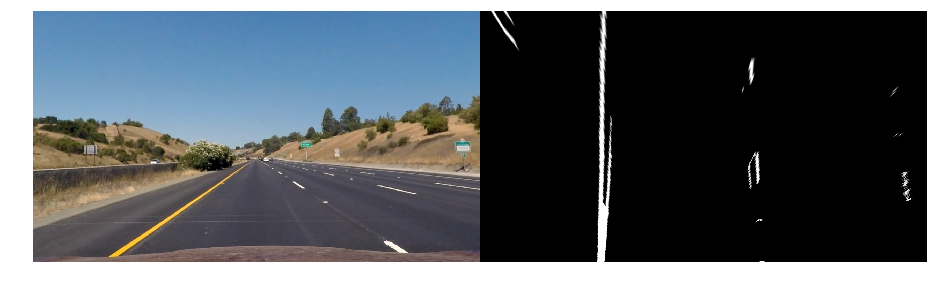

In [4]:
img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = lane_pipeline_warp(img,camparam,dpRslt=True)

#### visualize histogram of sliced binary image (0~300)

In [5]:
## test function
def histogram_on_sliced_image_test(img, ymin, ymax) :
    sliced_img = img[ymin:ymax,:]
    histogram = np.sum(sliced_img, axis=0)
    mid_x = histogram.shape[0]//2
    left_x = np.argmax(histogram[:mid_x]) # find left pick x 
    right_x = np.argmax(histogram[mid_x:]) + mid_x # find right pick x
    
    max_val = math.ceil(np.max(histogram)+100)
    #return histogram
    
    fig, ax1 = plt.subplots(figsize=(16, 5))
    ax1.imshow(np.flip(sliced_img, 0),cmap='gray')
    ax1.axis('tight')
    ax1.set_ylabel('y px')
    ax1.set_ylabel('image width')
    
    ax2 = ax1.twinx()
    ax2.plot(histogram, color='red')
    ax2.vlines(mid_x,0,sliced_img.shape[1],color='blue')
    ax2.vlines(left_x,0,sliced_img.shape[1],color='yellow')
    ax2.vlines(right_x,0,sliced_img.shape[1],color='violet')
    ax2.set_ylabel('histogram value')
    #ax2.axis('tight')

    #axs[0].gca().invert_yaxis()
    #plt.show()

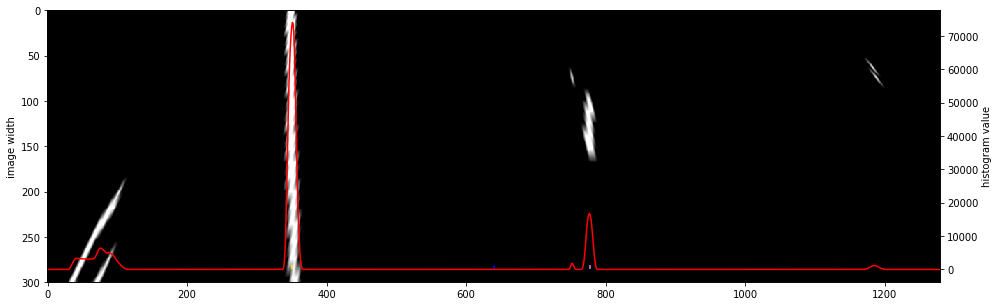

In [6]:
histogram = histogram_on_sliced_image_test(img,0,300)

#### visualize histogram of sliced binary : half the image ( img.shape[0]//2 ~ img.shape[0 )

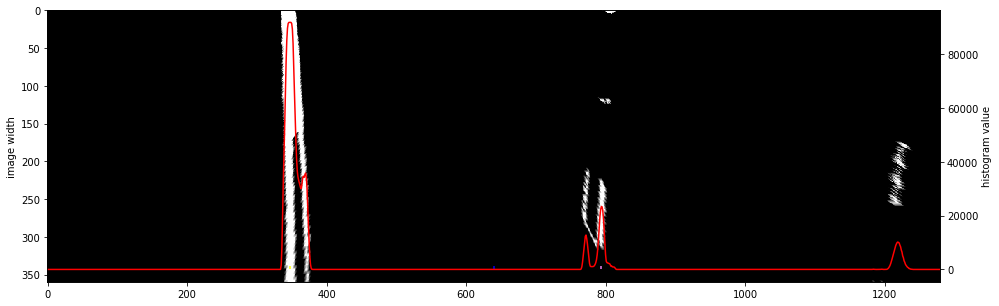

In [7]:
histogram_on_sliced_image_test(img,img.shape[0]//2,img.shape[0])

### Locate Lane pixels 

In [8]:
## Define a global variable to keep track last status for video processing
g_left_fit=None
g_right_fit=None

def detect_lane_pixels(binary_warped,forceSlidingWindow=True,dpRslt=False) :
    global g_left_fit,g_right_fit
    # Create an output image to draw on and  visualize the result    
    bin_img = binary_warped.astype(int)
    bin_img = binary_warped * 255
    out_img = cv2.merge([bin_img,bin_img,bin_img])

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    def sliding_windos_search() :
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        sliced_img = binary_warped[binary_warped.shape[0]//2:,:]
        histogram = np.sum(sliced_img, axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image left green (0,255,255) thickness = 3
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,255), 3) 
            #histogram_on_sliced_image_test(img,win_y_low,win_y_high)
            # Draw the windows on the visualization image right green (0,255,0) thickness = 3
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & # y boundary check 
                              (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        return np.concatenate(left_lane_inds), np.concatenate(right_lane_inds)

    
    def polyline_search():
        left_fit = g_left_fit
        right_fit = g_right_fit
        ## Line area search from the last line
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                          & (nonzerox < (left_fit[0]*(nonzeroy**2)+ left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2)+ right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                           & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        return left_lane_inds, right_lane_inds
    
    if forceSlidingWindow : 
        left_lane_inds, right_lane_inds = sliding_windos_search()
    else :
        if g_left_fit is not None and g_right_fit is not None :
            try :
                left_lane_inds, right_lane_inds = polyline_search()
            except:
                left_lane_inds, right_lane_inds = sliding_windos_search()
        else : 
            left_lane_inds, right_lane_inds = sliding_windos_search()
        

    #left_lane_inds, right_lane_inds = sliding_windos_search()
    #left_lane_inds, right_lane_inds = polyline_search()

    # Mask Left Lane =  Red / Right Lane = Blue
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    try :
        left_fit = np.polyfit(lefty, leftx, 2)
        g_left_fit = left_fit
    except :
        left_fit = g_left_fit
    
    try :
        right_fit = np.polyfit(righty, rightx, 2)
        g_right_fit = right_fit        
    except :
        right_fit = g_right_fit

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## draw fit line directly on the image
    ## thickness = 5  # poly color = Yellow
    for i in range(0,5) :
        try : 
            out_img[ploty.astype(int), left_fitx.astype(int)+i] = [255,255,0]
            out_img[ploty.astype(int), right_fitx.astype(int)-i] = [255,255,0]
        except :
            pass
    
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.vstack([left_fitx-margin, ploty]).T])
    left_line_window2 = np.array([np.flipud(np.vstack([left_fitx+margin, ploty]).T)])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.vstack([right_fitx-margin, ploty]).T])
    right_line_window2 = np.array([np.flipud(np.vstack([right_fitx+margin,ploty]).T)])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.001, 0)
    
    if dpRslt :
        plt.imshow(result)
        # Plot up the fake data
        mark_size = 3
        plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
        plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
    return result

### 6. Determine the curvature of the lane and vehicle position with respect to center.
* Measuring curvature

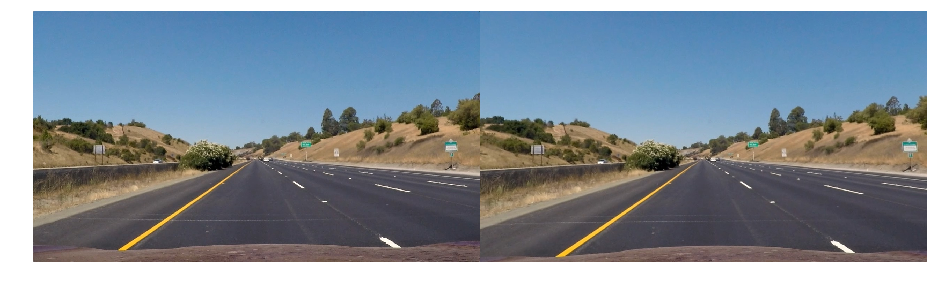

In [9]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = undistort_img(img, camparam, dpRslt=True )

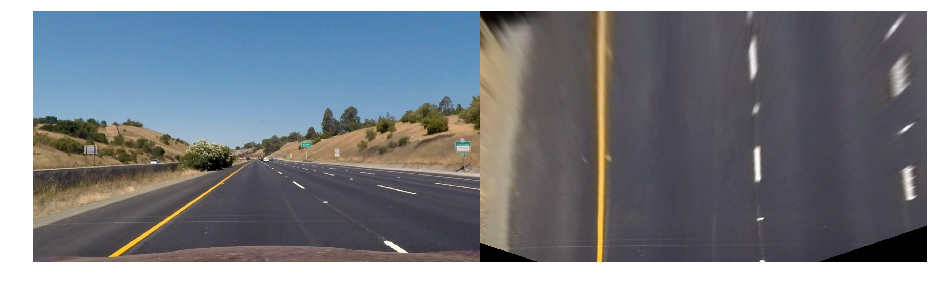

In [10]:
birdseye = warp(img,dpRslt=True)

lanewidthpx = 448 
lanelengthpx = 108 



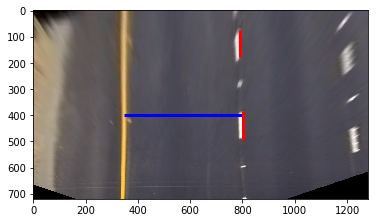

In [11]:
plt.imshow(birdseye)
plt.hlines(400,349,797,color='blue',linewidth=3)
lanewidthpx = 797 - 349 
plt.vlines(803,385,493,color='red',linewidth=3)
lanelengthpx = 493 - 385
plt.vlines(790,73,71+lanelengthpx,color='red',linewidth=3)
print ("lanewidthpx = {} \nlanelengthpx = {} \n".format(lanewidthpx,lanelengthpx))

In [12]:
########################################################################################
####
#### Improve detect_lane_pixels function with curvature calculation
####
########################################################################################
    
## Define a global variable to keep track last status for video processing
g_left_fit=None
g_right_fit=None
g_left_fit_cr=None
g_right_fit_cr=None

def detect_lane_pixels(binary_warped,forceSlidingWindow=True,dpRslt=False) :
    global g_left_fit   , g_right_fit
    global g_left_fit_cr, g_right_fit_cr
    
    # Create an output image to draw on and  visualize the result    
    bin_img = binary_warped.astype(int)
    bin_img = binary_warped * 255
    out_img = cv2.merge([bin_img,bin_img,bin_img])

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    
    def sliding_windos_search() :
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        sliced_img = binary_warped[binary_warped.shape[0]//2:,:]
        histogram = np.sum(sliced_img, axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image left green (0,255,255) thickness = 3
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,255), 3) 
            #histogram_on_sliced_image_test(img,win_y_low,win_y_high)
            # Draw the windows on the visualization image right green (0,255,0) thickness = 3
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & # y boundary check 
                              (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        return np.concatenate(left_lane_inds), np.concatenate(right_lane_inds)

    
    def polyline_search():
        left_fit = g_left_fit
        right_fit = g_right_fit
        ## Line area search from the last line
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                          & (nonzerox < (left_fit[0]*(nonzeroy**2)+ left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2)+ right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                           & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        return left_lane_inds, right_lane_inds
    
    if forceSlidingWindow : 
        left_lane_inds, right_lane_inds = sliding_windos_search()
    else :
        if g_left_fit is not None and g_right_fit is not None :
            try :
                left_lane_inds, right_lane_inds = polyline_search()
            except:
                left_lane_inds, right_lane_inds = sliding_windos_search()
        else : 
            left_lane_inds, right_lane_inds = sliding_windos_search()
        

    #left_lane_inds, right_lane_inds = sliding_windos_search()
    #left_lane_inds, right_lane_inds = polyline_search()

    # Mask Left Lane =  Red / Right Lane = Blue
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    try :
        left_fit = np.polyfit(lefty, leftx, 2)
        g_left_fit = left_fit
    except :
        left_fit = g_left_fit
    
    try :
        right_fit = np.polyfit(righty, rightx, 2)
        g_right_fit = right_fit        
    except :
        right_fit = g_right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.vstack([left_fitx-margin, ploty]).T])
    left_line_window2 = np.array([np.flipud(np.vstack([left_fitx+margin, ploty]).T)])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.vstack([right_fitx-margin, ploty]).T])
    right_line_window2 = np.array([np.flipud(np.vstack([right_fitx+margin,ploty]).T)])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    rslt_frame = cv2.addWeighted(out_img, 1, window_img, 0.25, 0)
    
    ## draw fit line directly on the image
    ## thickness = 5  # poly color = Yellow
    for i in range(0,5) :
        try : 
            rslt_frame[ploty.astype(int), left_fitx.astype(int)+i] = [255,255,0]
            rslt_frame[ploty.astype(int), right_fitx.astype(int)-i] = [255,255,0]
        except :
            pass
    
    # Draw the lane onto the warped blank image
    #cv2.polylines(out_img,np.int_([left_line_pts]), True,(0,255, 0), thickness=10)
    #cv2.polylines(out_img,np.int_([right_line_pts]), True,(0,255, 0), thickness=10)
    
    result = rslt_frame
    ##################################################################
    # Calculate curvature
    y_eval = np.max(ploty)
    #print(left_curverad, right_curverad)
    lanewidthpx = 448 
    lanelengthpx = 108 
    ym_per_pix = 3.0/lanelengthpx # meters per pixel in y dimension
    xm_per_pix = 3.7/lanewidthpx # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    try :
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        g_left_fit_cr = left_fit_cr
    except :
        left_fit_cr = g_left_fit_cr
    
    try :
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        g_right_fit_cr = right_fit_cr
    except :
        right_fit_cr = g_right_fit_cr
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Calculate car position from the center of the frame
    # Check the x position of left lane and right lane at 
    frame_center = binary_warped.shape[1]//2 
    height_idx = binary_warped.shape[0] - 10 
    lane_center = ( right_fitx[height_idx] - left_fitx[height_idx] ) //2 + left_fitx[height_idx]
    #print(lane_center,"lane_Center")
    #print(frame_center,"frame_center")
    dist_from_center = (lane_center - frame_center) * xm_per_pix
    #print(dist_from_center,"dist_from_center_px")
    #print(dist_from_center,"center_dist")
    ##################################################################
        
    if dpRslt :
        plt.imshow(result)
        # Plot up the fake data
        mark_size = 3
        plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
        plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
    return result, left_curverad, right_curverad, dist_from_center

### Curvature measure with test data

# sample : 8  sampling_rate : 1.0  # of data : 8
size =  (256, 256, 3)


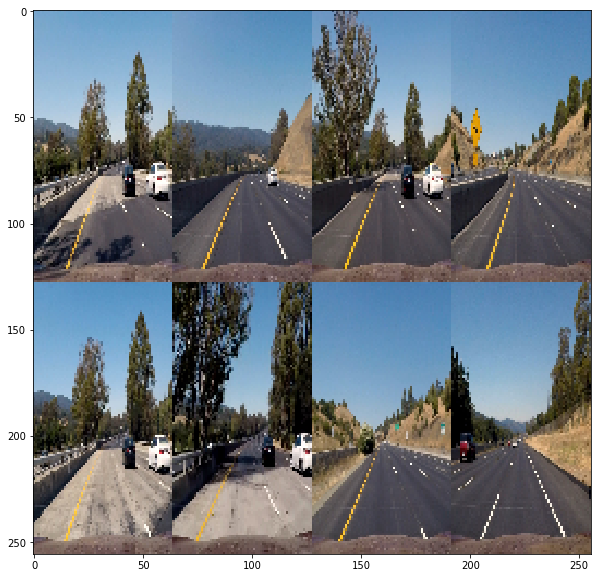

In [13]:
# Check camera calibration images
test_imgs = vd.show_sampled_dataset_from_dir('test_images',filepat='*.jpg',sampling_rate=1.0)

### Apply whole processing pipeline

In [14]:
def lane_pipeline(img,camparam,forceSlidingWindow=False,dpRslt=False) :
    img = undistort_img(img, camparam, dpRslt=False )
    #bin_img = frame_binaryzation(img,dspRslt=False)
    bin_img = frame_binaryzation(img,dspRslt=False,thresh=(120,255),dspDebug=False)
    warp_img = (warp(bin_img,dpRslt=False))
    lanepx_img, left_curverad, right_curverad, dist_from_center = \
        detect_lane_pixels(warp_img,forceSlidingWindow=forceSlidingWindow,dpRslt=False)
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs] 
        axs[0].imshow(img)
        axs[1].imshow(lanepx_img)
        print (img_path)
        print ("rad : {:7.2f} m".format(left_curverad))
        print ("dist from center : {:7.2f} m ".format(dist_from_center))
        plt.show()
    
    return lanepx_img

#### Test witrh single images

In [15]:
## Load camera calibration parameters
with open('camparam.p', 'rb') as handle:
    camparam_loaded = pickle.load(handle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test4.jpg
rad :  613.43 m
dist from center :   -0.13 m 


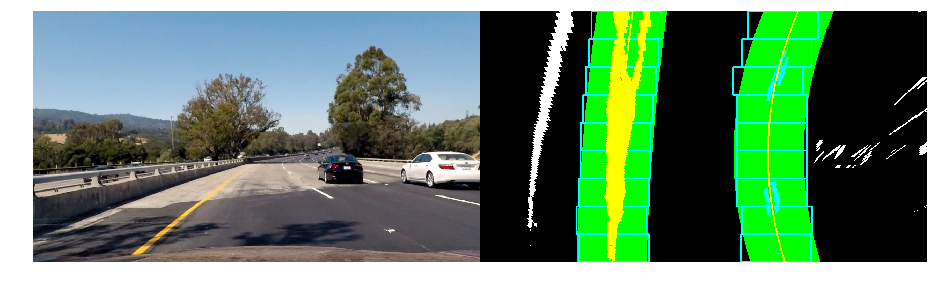

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test3.jpg
rad :  658.05 m
dist from center :   -0.38 m 


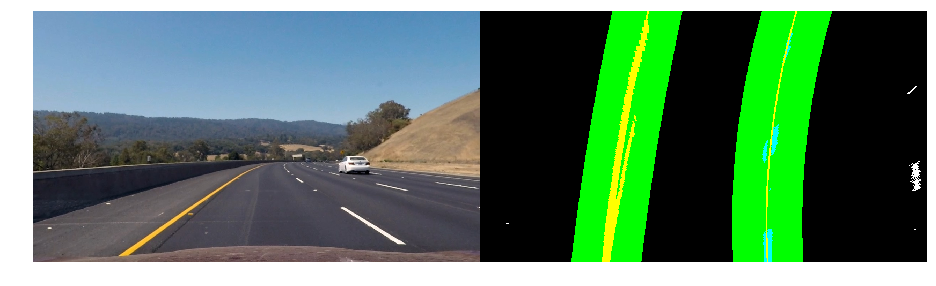

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test6.jpg
rad : 1612.41 m
dist from center :   -0.14 m 


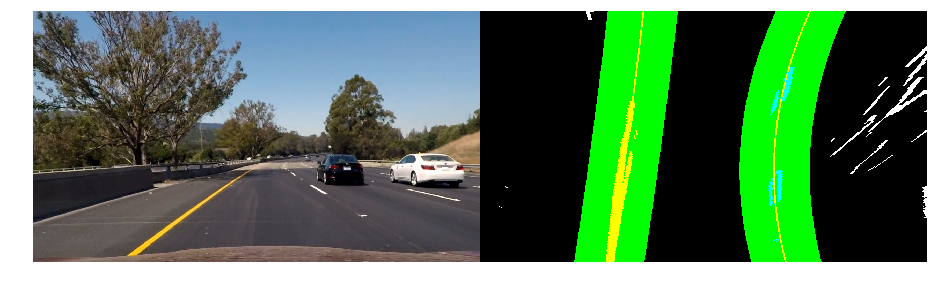

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test2.jpg
rad :  316.13 m
dist from center :   -0.18 m 


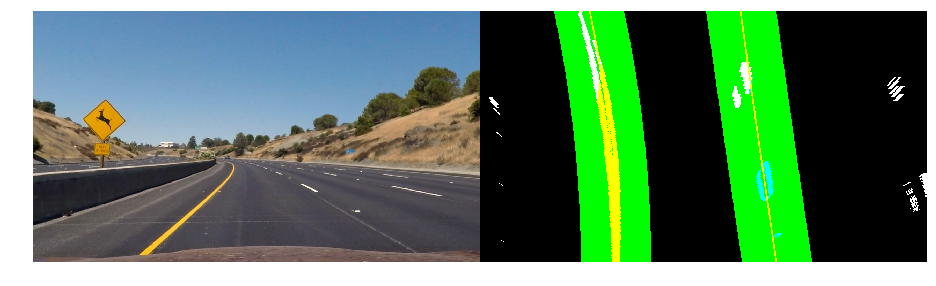

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test1.jpg
rad :   77.00 m
dist from center :   -0.50 m 


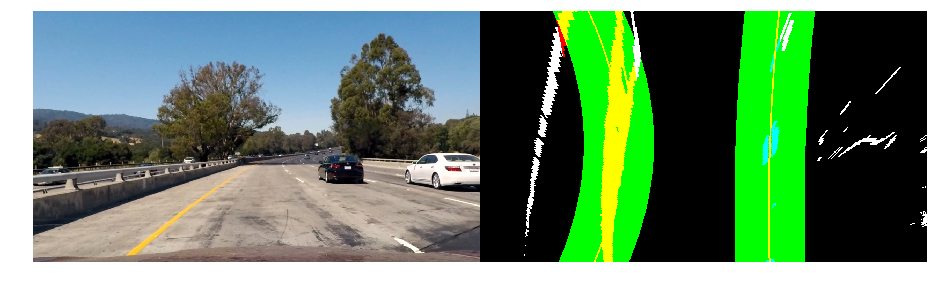

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test5.jpg
rad :  211.61 m
dist from center :   -0.55 m 


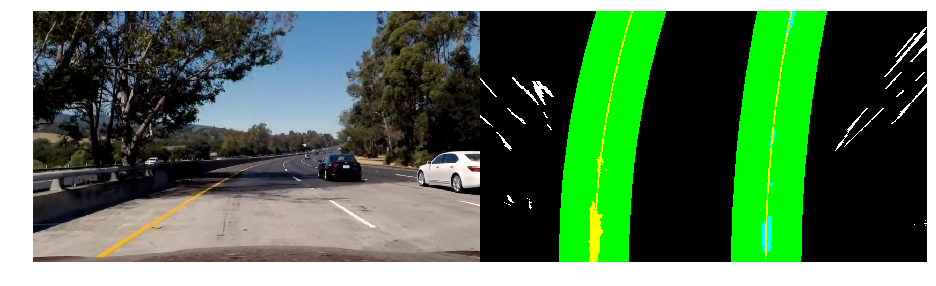

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/straight_lines1.jpg
rad :  924.01 m
dist from center :   -0.53 m 


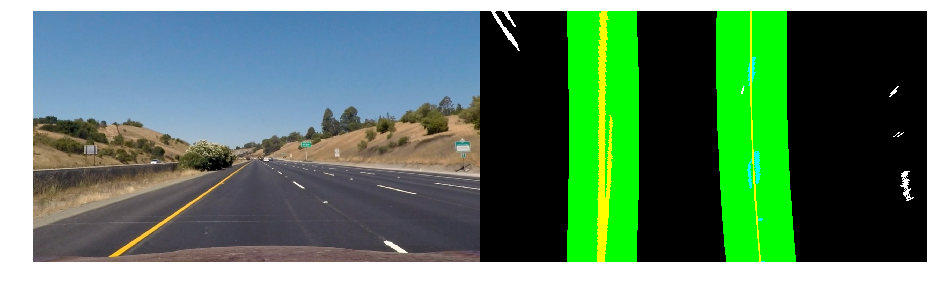

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/straight_lines2.jpg
rad : 2265.59 m
dist from center :   -0.51 m 


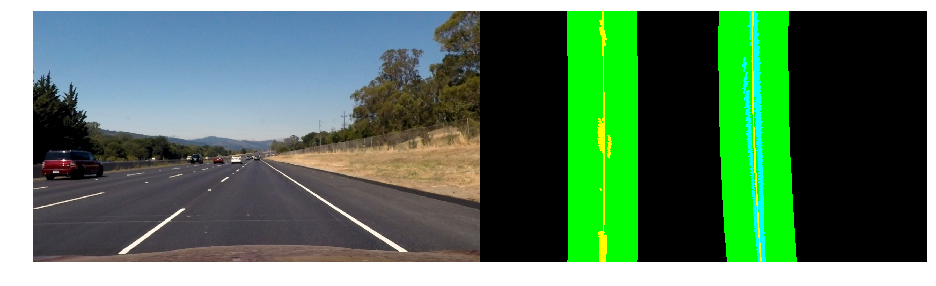

In [16]:
for img_path in test_imgs :
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = lane_pipeline(img,camparam_loaded,forceSlidingWindow=False,dpRslt=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


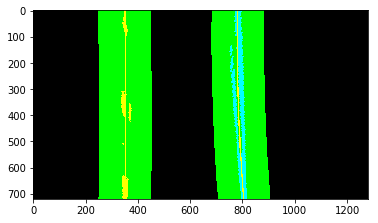

In [17]:
plt.imshow(img)

#### Apply to video

In [18]:
## Input Video
project_video = 'project_video.mp4'
cahllenge_video = 'challenge_video.mp4'
harder_cahllenge_video = 'harder_challenge_video.mp4'

## Ouput
lanepx_project_video = 'temp/lanepx_project_video.mp4'
lanepx_cahllenge_video = 'temp/lanepx_challenge_video.mp4'
lanepx_harder_cahllenge_video = 'temp/lanepx_harder_challenge_video.mp4'

In [19]:
## Load camera calibration parameters
with open('camparam.p', 'rb') as handle:
    camparam_loaded = pickle.load(handle)

## Process project_video
clip = VideoFileClip(project_video)#.subclip(0,0.5)
## Start with sliding window for the first frame
g_left_fit=None; g_right_fit=None;g_left_fit_cr=None; g_right_fit_cr=None
proc_clip = clip.fl_image(partial(lane_pipeline, camparam=camparam_loaded,forceSlidingWindow=False,dpRslt=False))
%time proc_clip.write_videofile(lanepx_project_video, audio=False)
#'''
## Process cahllenge_video
clip = VideoFileClip(cahllenge_video)#.subclip(0,1)
## Start with sliding window for the first frame
g_left_fit=None; g_right_fit=None;g_left_fit_cr=None; g_right_fit_cr=None
proc_clip = clip.fl_image(partial(lane_pipeline, camparam=camparam_loaded,forceSlidingWindow=False,dpRslt=False))
%time proc_clip.write_videofile(lanepx_cahllenge_video, audio=False)

## Process harder_cahllenge_video
clip = VideoFileClip(harder_cahllenge_video)#.subclip(0,1)
## Start with sliding window for the first frame
g_left_fit=None; g_right_fit=None;g_left_fit_cr=None; g_right_fit_cr=None
proc_clip = clip.fl_image(partial(lane_pipeline, camparam=camparam_loaded,forceSlidingWindow=False,dpRslt=False))
%time proc_clip.write_videofile(lanepx_harder_cahllenge_video, audio=False)
#'''

[MoviePy] >>>> Building video temp/lanepx_project_video.mp4
[MoviePy] Writing video temp/lanepx_project_video.mp4


100%|█████████▉| 1260/1261 [11:13<00:00,  1.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: temp/lanepx_project_video.mp4 

CPU times: user 2h 40min 45s, sys: 24min 29s, total: 3h 5min 14s
Wall time: 11min 13s
[MoviePy] >>>> Building video temp/lanepx_challenge_video.mp4
[MoviePy] Writing video temp/lanepx_challenge_video.mp4


100%|██████████| 485/485 [03:57<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: temp/lanepx_challenge_video.mp4 

CPU times: user 57min 27s, sys: 9min 15s, total: 1h 6min 42s
Wall time: 3min 57s
[MoviePy] >>>> Building video temp/lanepx_harder_challenge_video.mp4
[MoviePy] Writing video temp/lanepx_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [10:18<00:00,  1.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: temp/lanepx_harder_challenge_video.mp4 

CPU times: user 2h 30min 49s, sys: 22min 31s, total: 2h 53min 20s
Wall time: 10min 19s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
<video width="960" height="540" controls>
  <source src="{1}">
</video>
<video width="960" height="540" controls>
  <source src="{2}">
</video>
""".format(lanepx_project_video,lanepx_cahllenge_video,lanepx_harder_cahllenge_video))